# Building the SVM model for classifying DDoS and PortScanning

## Imports

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

## Save the scaler object

In [21]:
scaler = StandardScaler(with_mean=True)

## Helper Functions

In [22]:
# updated print_confusion_matrix for multi-class classification
def printConfusionMatrix(cm, y_true, normalize=False):
    # get unique class labels
    labels = sorted(set(y_true))

    # visualize the confusion matrix with a heatmap
    plt.figure(figsize=(8, 6))  # set figure size
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()


# function to calculate TP, FP, FN, TN for each class
def calculateMetrics(cm):
    """
    Calculate True Positives, False Positives, False Negatives, and True Negatives
    for each class using the confusion matrix.
    """
    metrics = {}
    for classIdx in range(len(cm)):
        tp = cm[classIdx, classIdx]
        fp = cm[:, classIdx].sum() - tp
        fn = cm[classIdx, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        metrics[classIdx] = {"TP": tp, "FP": fp, "FN": fn, "TN": tn}
    return metrics


# function to scale specific columns in the data using Standard Scaler
def scaleData(scaler, X_train, X_test, columns_to_scale, fileName = 'standard'):
    # make a copy of the data to avoid modifying the original DataFrame
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # fit and transform the specified columns for X_train
    X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
    # transform only for X_test (using the fit from X_train)
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
    joblib.dump(scaler, fileName + '_scaler.pkl')

    # return the scaled dataframes
    return X_train_scaled, X_test_scaled

# function for selecting
def filterBenignValues(dataframe, filterAmount):
    # separate benign rows and non-benign rows
    benign_rows = dataframe[dataframe['Label'] == 'BENIGN']
    non_benign_rows = dataframe[dataframe['Label'] != 'BENIGN']

    # randomly select half of the benign rows
    benign_sample = benign_rows.sample(frac = filterAmount, random_state = 42)  # Adjust random_state for reproducibility

    # combine and return the sampled benign rows with all non-benign rows
    result_df = pd.concat([benign_sample, non_benign_rows])
    return result_df

# function for counting the number of different label types and plotting the result
def count_and_plot(y, labelValues = ['Benign', 'DoS', 'DDoS', 'Port Scanning']):
    # count the number of rows for each label
    labelCounts = y.value_counts().sort_index()

    # calculate additional counts
    countBenign = labelCounts[0] if 0 in labelCounts.index else 0
    countOthers = labelCounts.drop(0).sum() if 0 in labelCounts.index else labelCounts.sum()

    # plot the counts
    plt.figure(figsize=(8, 6))
    plt.bar(labelCounts.index, labelCounts.values, color='skyblue', edgecolor='black')
    plt.xticks(labelCounts.index, labels=[f"{labelValues[lable]}" for lable in labelCounts.index])

    # add labels and show the plot
    plt.xlabel('Label Number')
    plt.ylabel('Number of Rows')
    plt.title(f'Row Counts for Each Label Number\n(Benign: {countBenign}, Others: {countOthers})')
    plt.tight_layout()
    plt.show()

# function for removing null and infi values
def remove_null_and_infi(X_train, X_test):
    X_train.fillna(X_train.mean(), inplace=True)
    X_test.fillna(X_test.mean(), inplace=True)

    X_train.replace(['max', float('inf'), float('-inf')], 1e10, inplace=True)
    X_test.replace(['max', float('inf'), float('-inf')], 1e10, inplace=True)

    # ensure no NaN or Inf values remain
    assert not X_train.isnull().any().any(), "X_train still contains NaN values!"
    assert not X_test.isnull().any().any(), "X_test still contains NaN values!"
    assert not (X_train == float('inf')).any().any(), "X_train still contains infinite values!"
    assert not (X_test == float('inf')).any().any(), "X_test still contains infinite values!"

# function for training an SVM model
def train_and_evaluate_svm(X_train, X_test, y_train, y_test, C=1, gamma='scale'):
    # initialize the SVM model with specific C and gamma values
    model = SVC(kernel='rbf', C=C, gamma=gamma) #, class_weight='balanced'
    
    # fit the model
    model.fit(X_train, y_train)

    # predict on the test set
    y_pred = model.predict(X_test)
    
    # calculate train and test accuracy
    trainAccuracy = accuracy_score(y_train, model.predict(X_train))
    testAccuracy = accuracy_score(y_test, y_pred)

    # generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # calculate TP, FP, FN, TN for each class
    metrics = calculateMetrics(cm)

    # generate the classification report
    classReport = classification_report(y_test, y_pred, output_dict=False)

    # print results
    print(f"Train Accuracy: {trainAccuracy:.2f}")
    print(f"Test Accuracy: {testAccuracy:.2f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nMetrics for each class:")
    for classIdx, values in metrics.items():
        print(f"Class {classIdx} -> TP: {values['TP']}, FP: {values['FP']}, FN: {values['FN']}, TN: {values['TN']}")

    print("\nClassification Report:")
    print(classReport)

    # visualize the confusion matrix
    printConfusionMatrix(cm, y_test)

    return model

## Selected Columns

In [23]:
selectedColumns = [
    'Dst Port', 'Total Length of Fwd Packet', 'Fwd Packet Length Max',
    'Fwd Packet Length Mean', 'Bwd Packet Length Max', 'Bwd Packet Length Min',
    'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Bwd IAT Total',
    'Bwd IAT Max', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
    'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count', 'PSH Flag Count', 'URG Flag Count',
    'Average Packet Size', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg',
    'Subflow Fwd Bytes', 'Label'
]

## Only Port

Number of duplicate rows based on selected features: 0
Shape of dataset after removing duplicates: (423483, 91)
(226475, 22) (97061, 22) (226475,) (97061,)


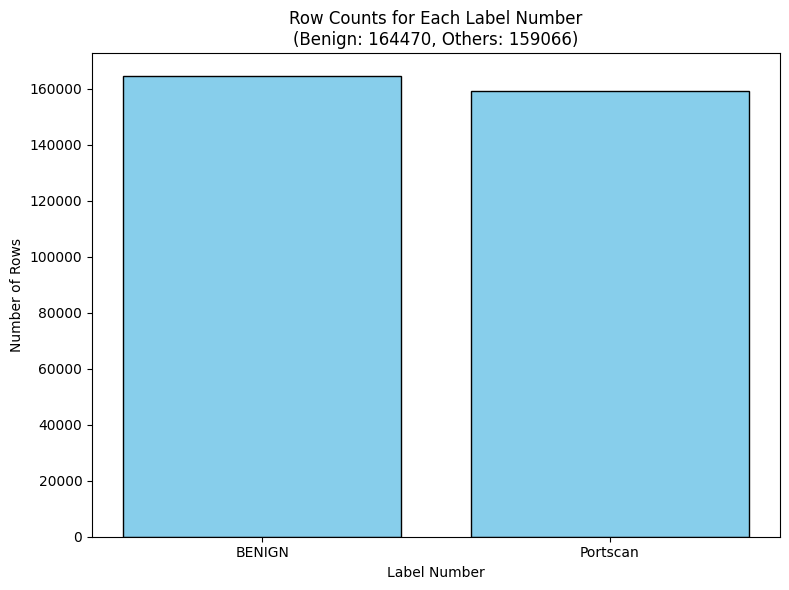

Train Accuracy: 1.00
Test Accuracy: 1.00

Confusion Matrix:
[[49059   317]
 [   26 47659]]

Metrics for each class:
Class 0 -> TP: 49059, FP: 26, FN: 317, TN: 47659
Class 1 -> TP: 47659, FP: 317, FN: 26, TN: 49059

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     49376
           1       0.99      1.00      1.00     47685

    accuracy                           1.00     97061
   macro avg       1.00      1.00      1.00     97061
weighted avg       1.00      1.00      1.00     97061



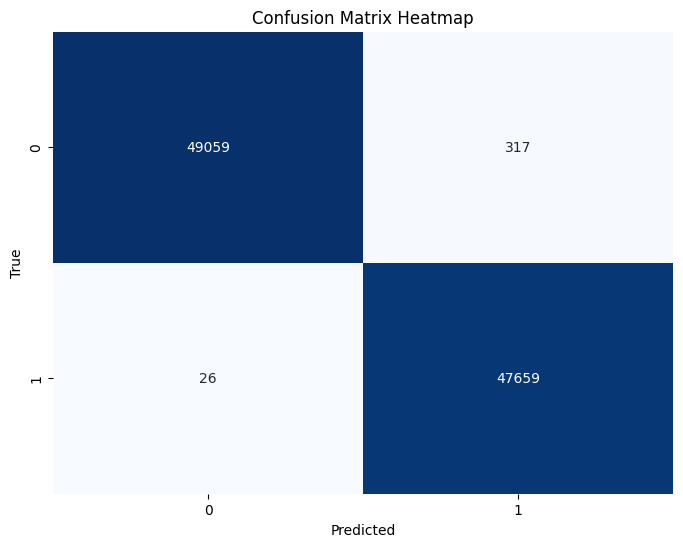

Runtime: 0.83 minutes
Model saved successfully!


In [11]:
portDataframe = pd.read_csv('CICIDS_Port_2.csv')
portDataframe.columns = portDataframe.columns.str.strip()
portDataframe = filterBenignValues(portDataframe, 0.57)

# check for duplicates in the subset of selected features
duplicates_mask = portDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
portDataframe = portDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {portDataframe.shape}")

# select relevant columns 
portDataframe = portDataframe[selectedColumns]
portDataframe = portDataframe[(portDataframe['Label'] == 'BENIGN') | (portDataframe['Label'] == 'Portscan')]

# train-test split
X = portDataframe.drop(columns=['Label'])
y = portDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'Portscan': 1
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y, ['BENIGN', 'Portscan'])

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale, 'port')

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'port_svm_model_2.pkl')  
print("Model saved successfully!")

## Only DDoS

Number of duplicate rows based on selected features: 0
Shape of dataset after removing duplicates: (360003, 91)
(137293, 22) (58841, 22) (137293,) (58841,)


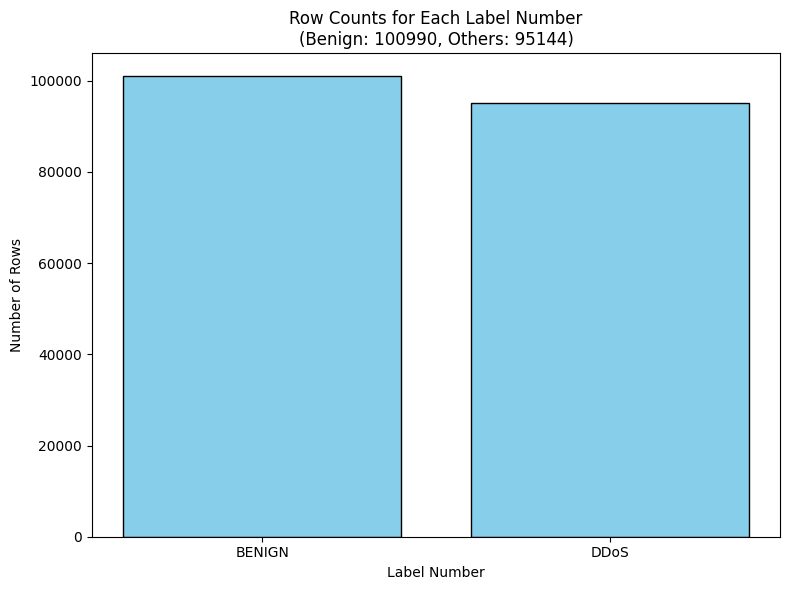

Train Accuracy: 1.00
Test Accuracy: 1.00

Confusion Matrix:
[[30132     0]
 [    5 28704]]

Metrics for each class:
Class 0 -> TP: 30132, FP: 5, FN: 0, TN: 28704
Class 1 -> TP: 28704, FP: 0, FN: 5, TN: 30132

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30132
           1       1.00      1.00      1.00     28709

    accuracy                           1.00     58841
   macro avg       1.00      1.00      1.00     58841
weighted avg       1.00      1.00      1.00     58841



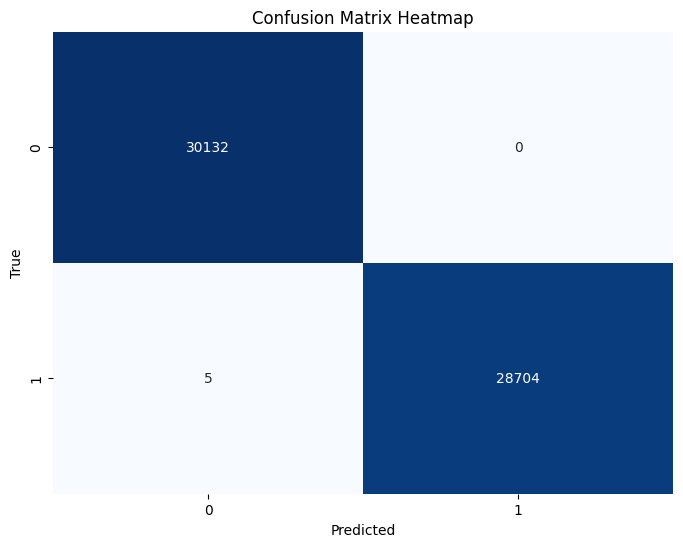

Runtime: 0.06 minutes
Model saved successfully!


In [12]:
ddosDataframe = pd.read_csv('CICIDS_Port_2.csv')
ddosDataframe.columns = ddosDataframe.columns.str.strip()
ddosDataframe = filterBenignValues(ddosDataframe, 0.35)

# check for duplicates in the subset of selected features
duplicates_mask = ddosDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
ddosDataframe = ddosDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {ddosDataframe.shape}")

# select relevant columns 
ddosDataframe = ddosDataframe[selectedColumns]
ddosDataframe = ddosDataframe[(ddosDataframe['Label'] == 'BENIGN') | (ddosDataframe['Label'] == 'DDoS')]

# train-test split
X = ddosDataframe.drop(columns=['Label'])
y = ddosDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'DDoS': 1
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y, ['BENIGN', 'DDoS'])

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale, 'ddos')

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'ddos_svm_model_2.pkl')  
print("Model saved successfully!")

## Only DoS

Number of duplicate rows based on selected features: 0
Shape of dataset after removing duplicates: (353037, 91)
(243005, 22) (104145, 22) (243005,) (104145,)


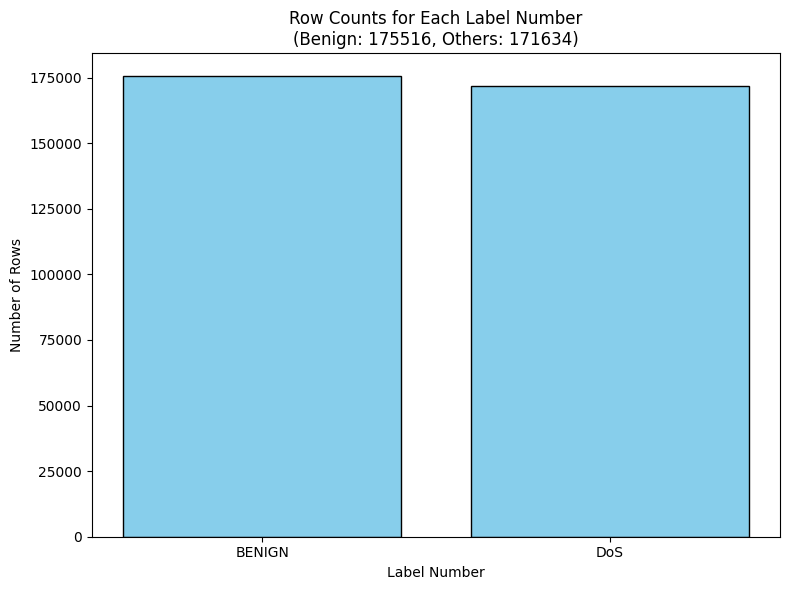

Train Accuracy: 1.00
Test Accuracy: 1.00

Confusion Matrix:
[[52716    23]
 [  247 51159]]

Metrics for each class:
Class 0 -> TP: 52716, FP: 247, FN: 23, TN: 51159
Class 1 -> TP: 51159, FP: 23, FN: 247, TN: 52716

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52739
           1       1.00      1.00      1.00     51406

    accuracy                           1.00    104145
   macro avg       1.00      1.00      1.00    104145
weighted avg       1.00      1.00      1.00    104145



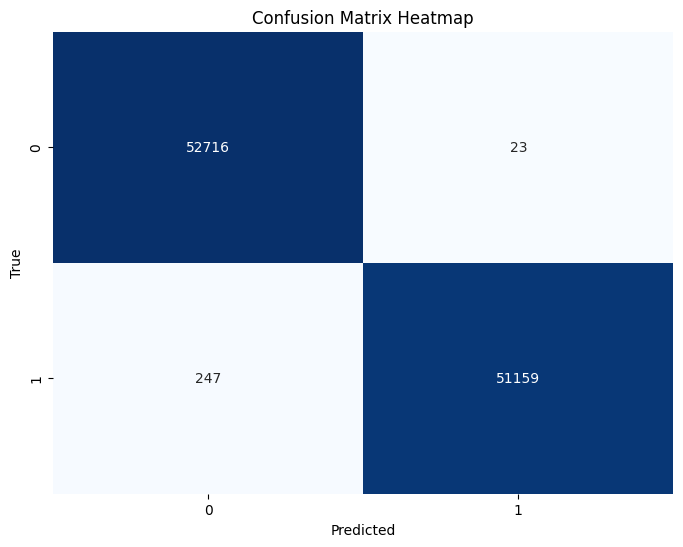

Runtime: 1.02 minutes
Model saved successfully!


In [13]:
dosDataframe = pd.read_csv('CICIDS_DoS_2.csv')
dosDataframe.columns = dosDataframe.columns.str.strip()
dosDataframe = filterBenignValues(dosDataframe, 0.55)

# check for duplicates in the subset of selected features
duplicates_mask = dosDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
dosDataframe = dosDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {dosDataframe.shape}")

# select relevant columns 
dosDataframe = dosDataframe[selectedColumns]
dosDataframe = dosDataframe[(dosDataframe['Label'] == 'BENIGN') | (dosDataframe['Label'] == 'DoS Hulk') | (dosDataframe['Label'] == 'DoS GoldenEye') | (dosDataframe['Label'] == 'DoS Slowloris') | (dosDataframe['Label'] == 'DoS Slowhttptest')]

# train-test split
X = dosDataframe.drop(columns=['Label'])
y = dosDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'DoS Hulk': 1, 'DoS GoldenEye': 1, 'DoS Slowloris': 1, 'DoS Slowhttptest': 1
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y, ['BENIGN', 'DoS'])

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale, 'dos')

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'dos_svm_model_2.pkl')  
print("Model saved successfully!")

## Port and DoS

Number of duplicate rows based on selected features: 0
Shape of dataset after removing duplicates: (618833, 91)
(359099, 22) (153900, 22) (359099,) (153900,)


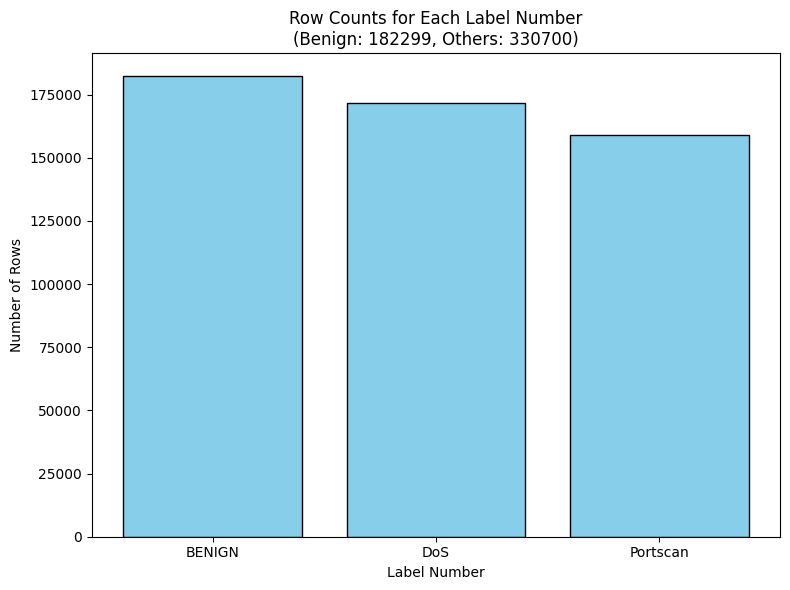

Train Accuracy: 1.00
Test Accuracy: 1.00

Confusion Matrix:
[[54342    32   272]
 [  273 51332     0]
 [   26     0 47623]]

Metrics for each class:
Class 0 -> TP: 54342, FP: 299, FN: 304, TN: 98955
Class 1 -> TP: 51332, FP: 32, FN: 273, TN: 102263
Class 2 -> TP: 47623, FP: 272, FN: 26, TN: 105979

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     54646
           1       1.00      0.99      1.00     51605
           2       0.99      1.00      1.00     47649

    accuracy                           1.00    153900
   macro avg       1.00      1.00      1.00    153900
weighted avg       1.00      1.00      1.00    153900



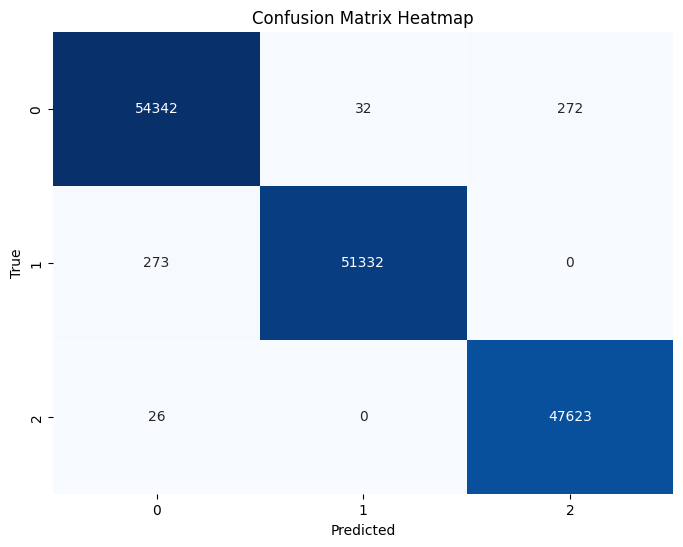

Runtime: 15.86 minutes
Model saved successfully!


In [14]:
portDataframe = pd.read_csv('CICIDS_Port_2.csv')
portDataframe.columns = portDataframe.columns.str.strip()
portDataframe = filterBenignValues(portDataframe, 0.30)

dosDataframe = pd.read_csv('CICIDS_DoS_2.csv')
dosDataframe.columns = dosDataframe.columns.str.strip()
dosDataframe = filterBenignValues(dosDataframe, 0.30)

# creating a single dataframe with bengin, ddos and portscannig
mergedDataframe = pd.concat([dosDataframe, portDataframe], axis=0)
mergedDataframe = mergedDataframe.sample(frac=1, random_state=42).reset_index(drop=True)

# check for duplicates in the subset of selected features
duplicates_mask = mergedDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
mergedDataframe = mergedDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {mergedDataframe.shape}")

# select relevant columns 
mergedDataframe = mergedDataframe[selectedColumns]
mergedDataframe = mergedDataframe[(mergedDataframe['Label'] == 'BENIGN') | (mergedDataframe['Label'] == 'Portscan') | (mergedDataframe['Label'] == 'DoS Hulk') | (mergedDataframe['Label'] == 'DoS GoldenEye') | (mergedDataframe['Label'] == 'DoS Slowloris') | (mergedDataframe['Label'] == 'DoS Slowhttptest')]

# train-test split
X = mergedDataframe.drop(columns=['Label'])
y = mergedDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'DoS Hulk': 1, 'DoS GoldenEye': 1, 'DoS Slowloris': 1, 'DoS Slowhttptest': 1,
    'Portscan': 2
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y, ['BENIGN', 'DoS', 'Portscan'])

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale, 'port_dos')

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'port_dos_svm_model_2.pkl')  
print("Model saved successfully!")

## Port and DDoS

Number of duplicate rows based on selected features: 0
Shape of dataset after removing duplicates: (432139, 91)
(299135, 22) (128201, 22) (299135,) (128201,)


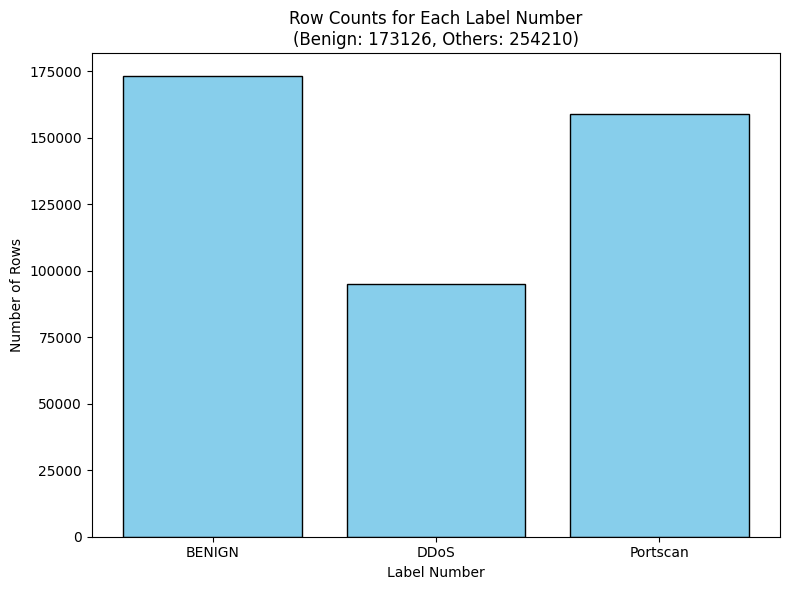

Train Accuracy: 1.00
Test Accuracy: 1.00

Confusion Matrix:
[[51538     0   280]
 [    0 28675    10]
 [   31    29 47638]]

Metrics for each class:
Class 0 -> TP: 51538, FP: 31, FN: 280, TN: 76352
Class 1 -> TP: 28675, FP: 29, FN: 10, TN: 99487
Class 2 -> TP: 47638, FP: 290, FN: 60, TN: 80213

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     51818
           1       1.00      1.00      1.00     28685
           2       0.99      1.00      1.00     47698

    accuracy                           1.00    128201
   macro avg       1.00      1.00      1.00    128201
weighted avg       1.00      1.00      1.00    128201



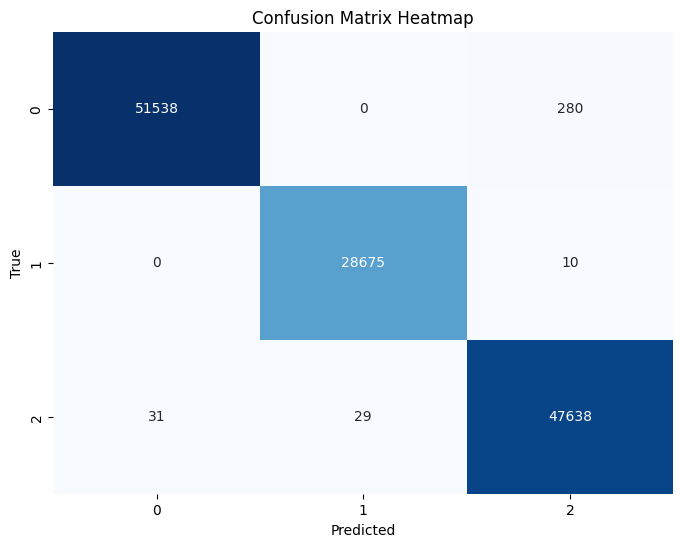

Runtime: 3.27 minutes
Model saved successfully!


In [15]:
portDdosDataframe = pd.read_csv('CICIDS_Port_2.csv')
portDdosDataframe.columns = portDdosDataframe.columns.str.strip()
portDdosDataframe = filterBenignValues(portDdosDataframe, 0.60)

# check for duplicates in the subset of selected features
duplicates_mask = portDdosDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
portDdosDataframe = portDdosDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {portDdosDataframe.shape}")

# select relevant columns 
portDdosDataframe = portDdosDataframe[selectedColumns]
portDdosDataframe = portDdosDataframe[(portDdosDataframe['Label'] == 'BENIGN') | (portDdosDataframe['Label'] == 'Portscan') | (portDdosDataframe['Label'] == 'DDoS')]

# train-test split
X = portDdosDataframe.drop(columns=['Label'])
y = portDdosDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'DDoS': 1,
    'Portscan': 2
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y, ['BENIGN', 'DDoS', 'Portscan'])

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale, 'port_ddos')

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'port_ddos_svm_model_2.pkl')  
print("Model saved successfully!")

## DoS and DDoS

Number of duplicate rows based on selected features: 0
Shape of dataset after removing duplicates: (613062, 91)
(310314, 22) (132992, 22) (310314,) (132992,)


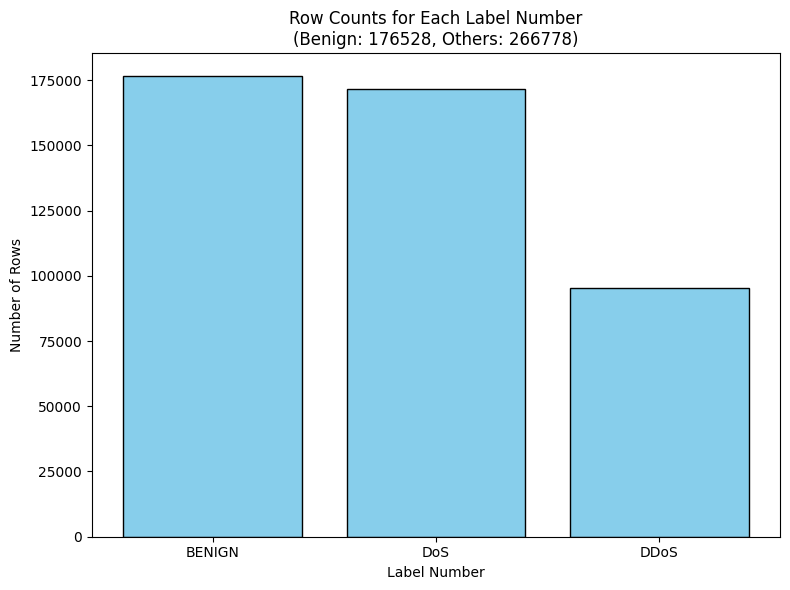

Train Accuracy: 1.00
Test Accuracy: 1.00

Confusion Matrix:
[[53125    33     0]
 [  261 51127     0]
 [    7     0 28439]]

Metrics for each class:
Class 0 -> TP: 53125, FP: 268, FN: 33, TN: 79566
Class 1 -> TP: 51127, FP: 33, FN: 261, TN: 81571
Class 2 -> TP: 28439, FP: 0, FN: 7, TN: 104546

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     53158
           1       1.00      0.99      1.00     51388
           2       1.00      1.00      1.00     28446

    accuracy                           1.00    132992
   macro avg       1.00      1.00      1.00    132992
weighted avg       1.00      1.00      1.00    132992



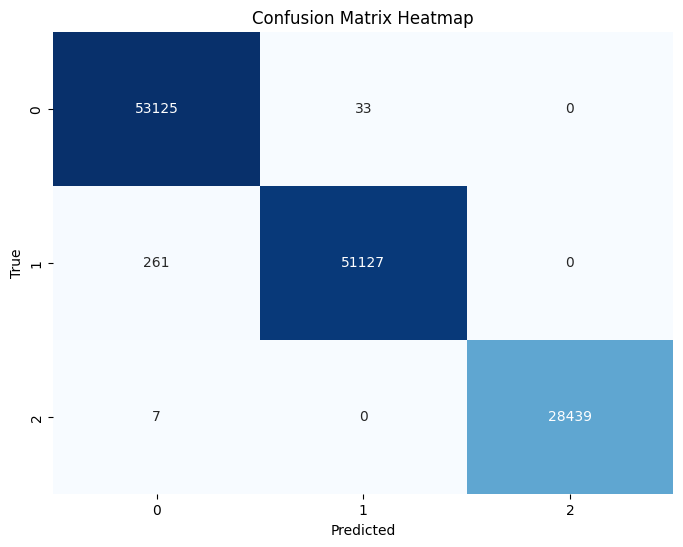

Runtime: 1.25 minutes
Model saved successfully!


In [16]:
ddosDataframe = pd.read_csv('CICIDS_Port_2.csv')
ddosDataframe.columns = ddosDataframe.columns.str.strip()
ddosDataframe = filterBenignValues(ddosDataframe, 0.28)

dosDataframe = pd.read_csv('CICIDS_DoS_2.csv')
dosDataframe.columns = dosDataframe.columns.str.strip()
dosDataframe = filterBenignValues(dosDataframe, 0.30)

# creating a single dataframe with bengin, ddos and portscannig
mergedDataframe = pd.concat([dosDataframe, ddosDataframe], axis=0)
mergedDataframe = mergedDataframe.sample(frac=1, random_state=42).reset_index(drop=True)

# check for duplicates in the subset of selected features
duplicates_mask = mergedDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
mergedDataframe = mergedDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {mergedDataframe.shape}")

# select relevant columns 
mergedDataframe = mergedDataframe[selectedColumns]
mergedDataframe = mergedDataframe[(mergedDataframe['Label'] == 'BENIGN') | (mergedDataframe['Label'] == 'DDoS') | (mergedDataframe['Label'] == 'DoS Hulk') | (mergedDataframe['Label'] == 'DoS GoldenEye') | (mergedDataframe['Label'] == 'DoS Slowloris') | (mergedDataframe['Label'] == 'DoS Slowhttptest')]

# train-test split
X = mergedDataframe.drop(columns=['Label'])
y = mergedDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'DoS Hulk': 1, 'DoS GoldenEye': 1, 'DoS Slowloris': 1, 'DoS Slowhttptest': 1,
    'DDoS': 2
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y, ['BENIGN', 'DoS', 'DDoS'])

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale, 'dos_ddos')

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'dos_ddos_svm_model_2.pkl')  
print("Model saved successfully!")

## Port, DoS and DDoS

Number of duplicate rows based on selected features: 0
Shape of dataset after removing duplicates: (613062, 91)
(421660, 22) (180712, 22) (421660,) (180712,)


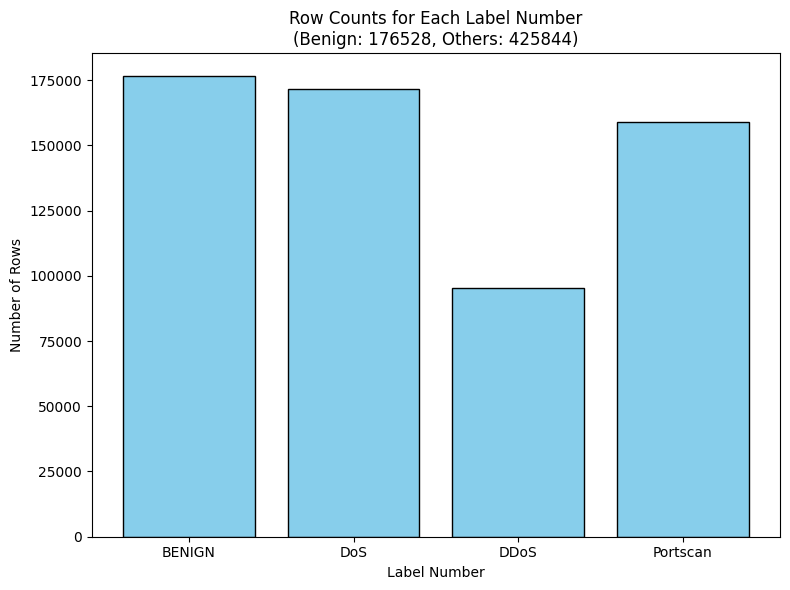

Train Accuracy: 1.00
Test Accuracy: 1.00

Confusion Matrix:
[[52844    54     0   230]
 [  216 51192     0     0]
 [    0     0 28691     8]
 [   26     0    18 47433]]

Metrics for each class:
Class 0 -> TP: 52844, FP: 242, FN: 284, TN: 127342
Class 1 -> TP: 51192, FP: 54, FN: 216, TN: 129250
Class 2 -> TP: 28691, FP: 18, FN: 8, TN: 151995
Class 3 -> TP: 47433, FP: 238, FN: 44, TN: 132997

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     53128
           1       1.00      1.00      1.00     51408
           2       1.00      1.00      1.00     28699
           3       1.00      1.00      1.00     47477

    accuracy                           1.00    180712
   macro avg       1.00      1.00      1.00    180712
weighted avg       1.00      1.00      1.00    180712



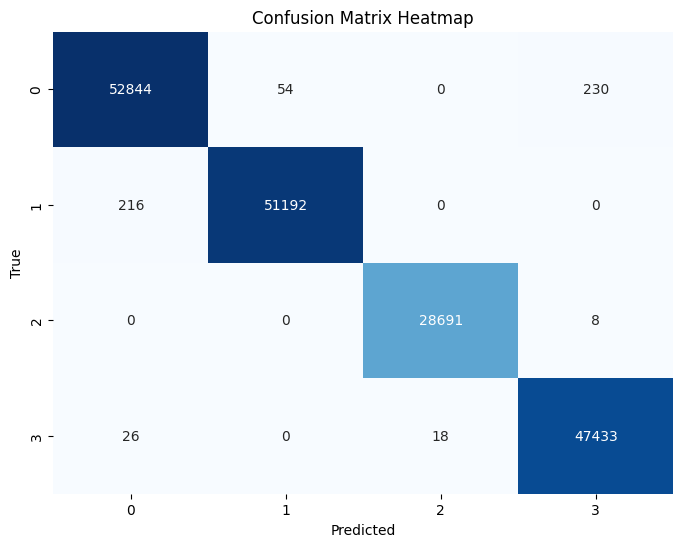

Runtime: 3.22 minutes
Model saved successfully!


In [17]:
portDdosDataframe = pd.read_csv('CICIDS_Port_2.csv')
portDdosDataframe.columns = portDdosDataframe.columns.str.strip()
portDdosDataframe = filterBenignValues(portDdosDataframe, 0.28)

dosDataframe = pd.read_csv('CICIDS_DoS_2.csv')
dosDataframe.columns = dosDataframe.columns.str.strip()
dosDataframe = filterBenignValues(dosDataframe, 0.30)

# creating a single dataframe with bengin, ddos and portscannig
mergedDataframe = pd.concat([dosDataframe, portDdosDataframe], axis=0)
mergedDataframe = mergedDataframe.sample(frac=1, random_state=42).reset_index(drop=True)

# check for duplicates in the subset of selected features
duplicates_mask = mergedDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
mergedDataframe = mergedDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {mergedDataframe.shape}")

# select relevant columns 
mergedDataframe = mergedDataframe[selectedColumns]
mergedDataframe = mergedDataframe[(mergedDataframe['Label'] == 'BENIGN') | (mergedDataframe['Label'] == 'Portscan') | (mergedDataframe['Label'] == 'DDoS') | (mergedDataframe['Label'] == 'DoS Hulk') | (mergedDataframe['Label'] == 'DoS GoldenEye') | (mergedDataframe['Label'] == 'DoS Slowloris') | (mergedDataframe['Label'] == 'DoS Slowhttptest')]

# train-test split
X = mergedDataframe.drop(columns=['Label'])
y = mergedDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'DoS Hulk': 1, 'DoS GoldenEye': 1, 'DoS Slowloris': 1, 'DoS Slowhttptest': 1,
    'DDoS': 2,
    'Portscan': 3
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y, ['BENIGN', 'DoS', 'DDoS', 'Portscan'])

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale, 'dos_ddos_port')

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'dos_ddos_port_svm_model_2.pkl')  
print("Model saved successfully!")

## ALL DATA

Number of duplicate rows based on selected features: 0
Shape of dataset after removing duplicates: (1044198, 91)
(723455, 22) (310053, 22) (723455,) (310053,)


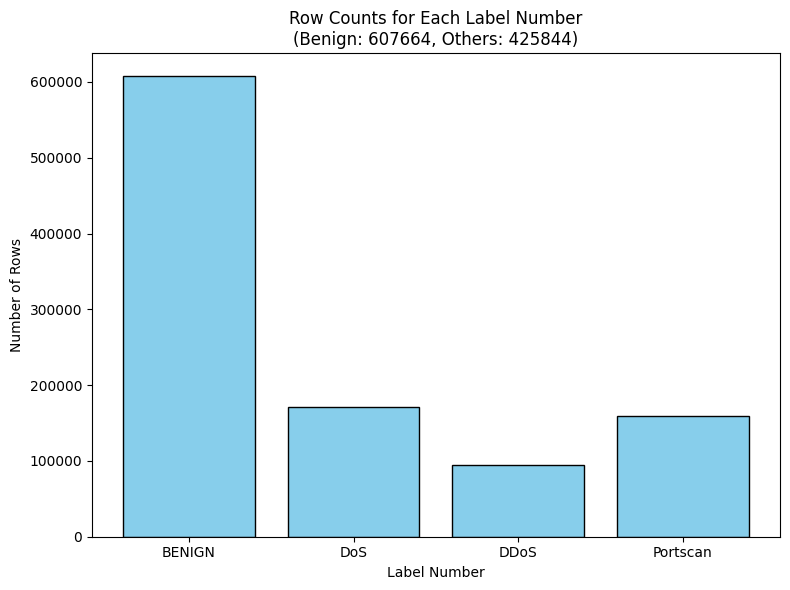

Train Accuracy: 1.00
Test Accuracy: 1.00

Confusion Matrix:
[[181236     79      1    772]
 [   365  51412      0      0]
 [     7      0  28510      0]
 [    33      0     23  47615]]

Metrics for each class:
Class 0 -> TP: 181236, FP: 405, FN: 852, TN: 127560
Class 1 -> TP: 51412, FP: 79, FN: 365, TN: 258197
Class 2 -> TP: 28510, FP: 24, FN: 7, TN: 281512
Class 3 -> TP: 47615, FP: 772, FN: 56, TN: 261610

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    182088
           1       1.00      0.99      1.00     51777
           2       1.00      1.00      1.00     28517
           3       0.98      1.00      0.99     47671

    accuracy                           1.00    310053
   macro avg       0.99      1.00      1.00    310053
weighted avg       1.00      1.00      1.00    310053



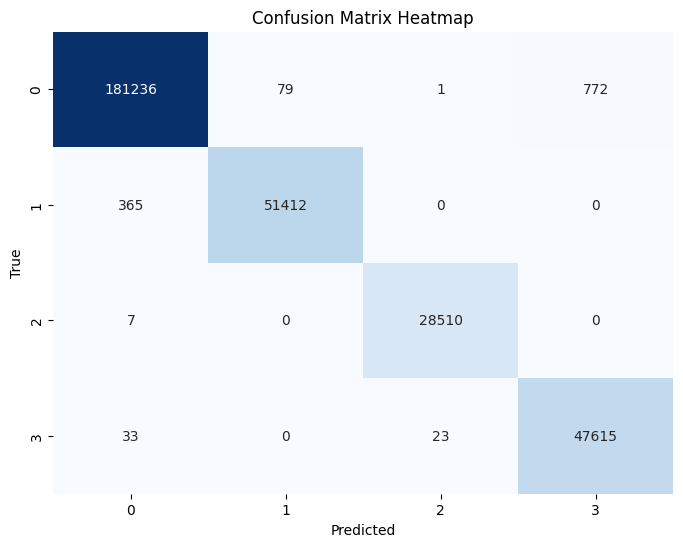

Runtime: 32.44 minutes
Model saved successfully!


In [18]:
portDdosDataframe = pd.read_csv('CICIDS_Port_2.csv')
portDdosDataframe.columns = portDdosDataframe.columns.str.strip()

dosDataframe = pd.read_csv('CICIDS_DoS_2.csv')
dosDataframe.columns = dosDataframe.columns.str.strip()

# creating a single dataframe with bengin, ddos and portscannig
mergedDataframe = pd.concat([dosDataframe, portDdosDataframe], axis=0)
mergedDataframe = mergedDataframe.sample(frac=1, random_state=42).reset_index(drop=True)

# check for duplicates in the subset of selected features
duplicates_mask = mergedDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
mergedDataframe = mergedDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {mergedDataframe.shape}")

# select relevant columns 
mergedDataframe = mergedDataframe[selectedColumns]
mergedDataframe = mergedDataframe[(mergedDataframe['Label'] == 'BENIGN') | (mergedDataframe['Label'] == 'Portscan') | (mergedDataframe['Label'] == 'DDoS') | (mergedDataframe['Label'] == 'DoS Hulk') | (mergedDataframe['Label'] == 'DoS GoldenEye') | (mergedDataframe['Label'] == 'DoS Slowloris') | (mergedDataframe['Label'] == 'DoS Slowhttptest')]

# train-test split
X = mergedDataframe.drop(columns=['Label'])
y = mergedDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'DoS Hulk': 1, 'DoS GoldenEye': 1, 'DoS Slowloris': 1, 'DoS Slowhttptest': 1,
    'DDoS': 2,
    'Portscan': 3
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y, ['BENIGN', 'DoS', 'DDoS', 'Portscan'])

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale, 'all_data')

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'all_data_svm_model_2.pkl')  
print("Model saved successfully!")

---

(140000, 22) (60000, 22) (140000,) (60000,)


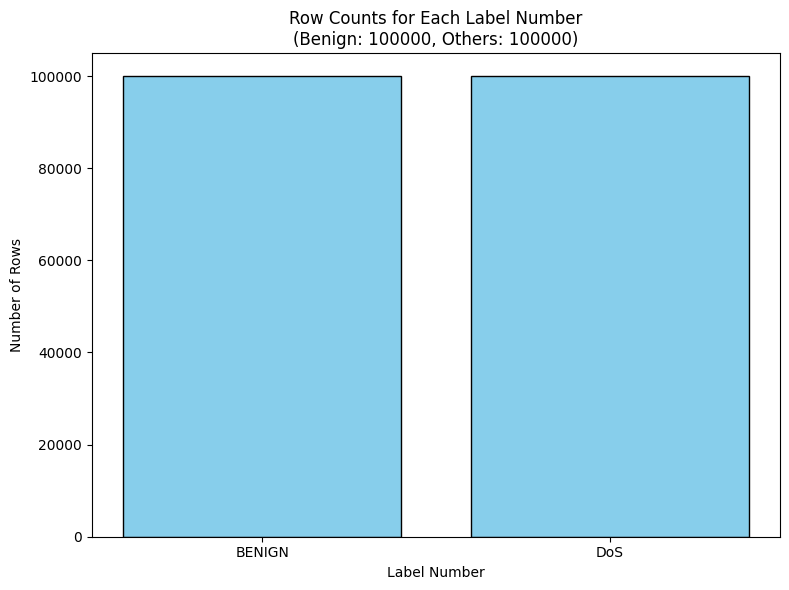

Train Accuracy: 1.00
Test Accuracy: 1.00

Confusion Matrix:
[[29852   117]
 [    0 30031]]

Metrics for each class:
Class 0 -> TP: 29852, FP: 0, FN: 117, TN: 30031
Class 1 -> TP: 30031, FP: 117, FN: 0, TN: 29852

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29969
           1       1.00      1.00      1.00     30031

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



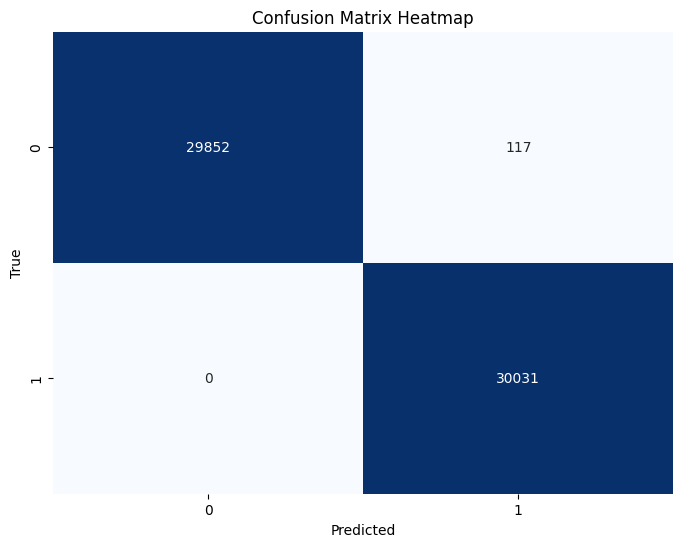

Runtime: 0.10 minutes
Model saved successfully!


In [32]:
dataframe = pd.read_csv('only_zeros.csv')
dataframe.columns = dataframe.columns.str.strip()

# train-test split
X = dataframe.drop(columns=['Label'])
y = dataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'DoS': 1
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y, ['BENIGN', 'DoS'])

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale, 'zeros_dos')

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'zeros_dos_svm_model_2.pkl')  
print("Model saved successfully!")